## Model used: Pretrained model keras_facenet

In [1]:
# Importing libraries used
import numpy as np
import pandas as pd
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from numpy import load
from numpy import expand_dims
from random import choice
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import cv2

Using TensorFlow backend.


<h1 style="text-align: justify;">FaceNet</h1>
<p style="text-align: justify;">FaceNet is a face recognition system developed in 2015 by researchers at Google that achieved then state-of-the-art results on a range of face recognition benchmark datasets. The FaceNet system can be used broadly thanks to multiple third-party open source implementations of the model and the availability of pre-trained models.</p>
<p style="text-align: justify;">The FaceNet system can be used to extract high-quality features from faces, called face embeddings, that can then be used to train a face identification system.</p>
<p style="text-align: justify;"><img src="https://miro.medium.com/max/1598/1*PaxDM5QUt8ZzUgCo2dzf4w.png" alt="" /></p>
<p style="text-align: justify;">&nbsp;</p>
<h2 id="d81d" class="jy jz fj as ka kb kc hy kd ke kf ic kg kh ki kj kk kl km kn ko kp kq kr ks kt bx" style="text-align: justify;">Triplet Loss and Selection</h2>
<p style="text-align: justify;"><img src="https://miro.medium.com/max/1116/1*IZEsEztCsy8ibdUaZ-7CRw.png" alt="" width="558" height="145" /></p>
<p style="text-align: justify;">The intuition behind triplet loss function is that we want our anchor image (image of a specific person A) to be closer to positive images (all the images of person A) as compared to negative images (all the other images).</p>
<p id="54ca" class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">Triplet loss function can be formally defined as:&nbsp;</p>
<p class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph=""><img src="https://miro.medium.com/max/1008/1*QnscpwgGTlznX_rTyRdKcQ.png" alt="" width="533" height="109" /></p>
<p class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph=""><img src="https://miro.medium.com/max/1304/1*xeyhNFIjzWL73yvd2qC9ew.png" alt="" /></p>
<p id="d5de" class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">Here, the superscript a, p and n correspond to anchor, positive and negative images respectively.</p>
<p id="eeb7" class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">Alpha is defined here as the margin between positive and negative pairs. It is essentially a threshold value which determines the difference between our image pairs. If let&rsquo;s say alpha is set to 0.5, then we want the difference between our anchor-positive and anchor-negative image pairs to be at least 0.5.</p>
<p class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">&nbsp;</p>
<p class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">&nbsp;</p>
<h2>Triplet Selection</h2>
<p id="53e6" class="ht hu fj hv b hw ku hy hz ia kv ic id ie kw ig ih ii kx ik il im ky io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">Choosing the correct image pairs is extremely important as there will be a lot of image pairs that will satisfy this condition and hence our model won&rsquo;t learn much from them and will also converge slowly because of that.</p>
<p id="ec7e" class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">In order to ensure fast convergence, it is crucial to select triplets that violate the triplet constraint.</p>
<p id="7f0e" class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">We essentially want to select the following:</p>
<p class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph=""><img src="https://miro.medium.com/max/1304/1*armBzkqmmYqPGJP0eFH0eg.png" alt="" /></p>
<p class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">&nbsp;</p>
<p id="2f71" class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">Eq (1) means that given an anchor image of person A, we want to find a positive image of A such that the distance between those two images is largest.</p>
<p id="c4ba" class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">Eq (2) means that given an anchor image of person A, we want to find a negative image such that the distance between those two images is smallest.</p>
<p class="ht hu fj hv b hw hx hy hz ia ib ic id ie if ig ih ii ij ik il im in io ip iq fb bx" style="text-align: justify;" data-selectable-paragraph="">So, we are just selecting the&nbsp;hard positives&nbsp;and&nbsp;hard negatives&nbsp;here. This approach helps us in speeding convergence as our model learns useful representations.</p>

<h1 style="text-align: justify;">Keras</h1>
<p style="text-align: justify;">Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result as fast as possible is key to doing good research.</p>
<p style="text-align: justify;">The core data structures of Keras are layers and models. The simplest type of model is the Sequential model, a linear stack of layers. For more complex architectures, you should use the Keras functional API, which allows to build arbitrary graphs of layers, or write models entirely from scratch via subclasssing.</p>

In [2]:
# Importing the pretrained deep learning model

from keras.models import load_model
model = load_model('facenet_keras.h5')

# Input and output of model 

print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Identity:0' shape=(None, 128) dtype=float32>]


/Users/billing/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


We can see that the model indeed expects square color images as input with the shape 160×160, and will output a face embedding as a 128 element vector.

In [3]:
# Importing mtcnn 

import mtcnn

print(mtcnn.__version__)

0.1.0


<h1 class="je jf fp jg b gn ky ji jj gq kz jl jm jn la jp jq jr lb jt ju jv lc jx jy jz fh bx" style="text-align: justify;">MTCNN</h1>
<p class="je jf fp jg b gn ky ji jj gq kz jl jm jn la jp jq jr lb jt ju jv lc jx jy jz fh bx" style="text-align: justify;" data-selectable-paragraph="">&nbsp;</p>
<p id="ff8c" class="je jf fp jg b gn ky ji jj gq kz jl jm jn la jp jq jr lb jt ju jv lc jx jy jz fh bx" style="text-align: justify;" data-selectable-paragraph="">MTCNN (Multi-task Cascaded Convolutional Neural Networks) is an algorithm consisting of 3 stages, which detects the bounding boxes of faces in an image along with their 5 Point Face Landmarks. Each stage gradually improves the detection results by passing it&rsquo;s inputs through a CNN, which returns candidate bounding boxes with their scores, followed by non max suppression.</p>
<p id="e005" class="je jf fp jg b gn jh ji jj gq jk jl jm jn jo jp jq jr js jt ju jv jw jx jy jz fh bx" style="text-align: justify;" data-selectable-paragraph="">In stage 1 the input image is scaled down multiple times to build an&nbsp;<strong class="jg kb">image pyramid</strong>&nbsp;and each scaled version of the image is passed through it&rsquo;s CNN. In stage 2 and 3 we extract image patches for each bounding box and resize them (<strong class="jg kb">24x24</strong>&nbsp;in stage 2 and&nbsp;<strong class="jg kb">48x48</strong>&nbsp;in stage 3) and forward them through the CNN of that stage. Besides bounding boxes and scores, stage 3 additionally computes&nbsp;<strong class="jg kb">5 face landmarks points</strong>&nbsp;for each bounding box.</p>

## Extracting the faces

In [4]:
def extract_face(filename, required_size=(160, 160)):
    
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image) # converting to numpy array
    
    detector = MTCNN()
    results = detector.detect_faces(pixels) # returns dictionary including coordinates of bounding box
    x1, y1, width, height = results[0]['box']  # extract the bounding box from the first face
  
    x1, y1 = abs(x1), abs(y1)  # as pixels are whole numbers
    x2, y2 = x1 + width, y1 + height  # obtaining the x2,y2 extreme coordinates using result dictionary
    face = pixels[y1:y2, x1:x2] # extracting the face using the calculated coordinates

    image = Image.fromarray(face)
    image = image.resize(required_size) #resizing to fit into facenet model as it takes 160x160 output
    face_array = asarray(image)
    
    return face_array

<p style="text-align: justify;"> The detect_faces function within the MTCNN class is called, to “detect faces” within the image we passed in and output the faces in “result”.
Result seems to be a dictionary that included the coordinates of the bounding box and facial landmarks, as well as the network’s confidence in classifying that area as a face.</p>

In [5]:
# Loading faces from each picture in training directory

def load_faces(directory):
    
    faces = list()
    for filename in listdir(directory):
        path = directory+"/"+filename
        face = extract_face(path)
        faces.append(face)
        
    return faces

In [6]:
# Loading dataset

def load_dataset(directory):
    
    X, y = list(), list()
    for subdir in listdir(directory):
        path = path =  directory+"/"+subdir
        if not isdir(path):
            continue
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces))]  # taking labels as name of folder
        print('Found %d images of person: %s' % (len(faces), subdir))
        X.extend(faces)
        y.extend(labels)
        
    return asarray(X), asarray(y)

In [7]:
# Loading training dataset

trainX, trainy = load_dataset('train')
print(trainX.shape, trainy.shape)

Found 14 images of person: ben_afflek
Found 5 images of person: Khushleen
Found 19 images of person: madonna
Found 17 images of person: elton_john
Found 22 images of person: mindy_kaling
Found 21 images of person: jerry_seinfeld
(98, 160, 160, 3) (98,)


In [8]:
# load test dataset

testX, testy = load_dataset('val')

Found 5 images of person: ben_afflek
Found 5 images of person: Khushleen
Found 5 images of person: madonna
Found 5 images of person: elton_john
Found 5 images of person: mindy_kaling
Found 5 images of person: jerry_seinfeld


## Extracting Facial Embeddings

To predict an embedding, first the pixel values of the image need to be suitably prepared to meet the expectations of the FaceNet model. This specific implementation of the FaceNet model expects that the pixel values are standardized. <br>
In order to make a prediction for one example in Keras, we must expand the dimensions so that the face array is one sample

In [9]:
# get the face embedding for one face

def get_embedding(model, face_pixels):
    
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std  # z scaling the values according to model

    samples = expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples) #predicting the embedding
    
    # It analyses the given image and returns numerical vectors that represent each detected face in the image
    
    return yhat[0]

In [10]:
# Embeddings of training data

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)

print(newTrainX.shape) # 128 dimension vector is returned by model for 93 images

(98, 128)


In [11]:
# Embeddings of training data

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)

print(newTestX.shape) # 128 dimension vector is returned by model for 93 images

(30, 128)


## Face Classification

In [12]:
# Normalize input vectors

in_encoder = Normalizer(norm='l2') # performing l2 normalization
trainX_emb = in_encoder.transform(newTrainX)
testX_emb = in_encoder.transform(newTestX)

In [13]:
# Encoding labels 

out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

In [14]:
# Fitting SVC classifier

model_svc = SVC(kernel='linear', probability=True)
model_svc.fit(trainX_emb, trainy_enc)

SVC(kernel='linear', probability=True)

In [15]:
# Test model on a random example from the test dataset

selection = choice([i for i in range(testX_emb.shape[0])])
random_face_pixels = testX[selection]
random_face_emb = testX_emb[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

Predicted: ben_afflek (85.74 percent probability)
Actual: ben_afflek


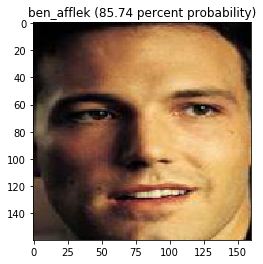

In [16]:
# Prediction and plotting the random face sample

samples = expand_dims(random_face_emb, axis=0)
yhat_class = model_svc.predict(samples)
yhat_prob = model_svc.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.2f percent probability)' % (predict_names[0], class_probability))
print('Actual: %s' % random_face_name[0])

pyplot.imshow(random_face_pixels)
title = "%s (%.2f percent probability)" % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

## Implementing the model on live webcam

In [ ]:
# Get a reference to webcam 

video_capture = cv2.VideoCapture(0)
detector = MTCNN()
required_size=(160, 160)

while True:
    
    # Grab a single frame of video
    ret, frame = video_capture.read()

    # Convert the image from BGR color (which OpenCV uses) to RGB color 
    rgb_frame = frame[:, :, ::-1]
    pixels = asarray(rgb_frame)
    
    # Extracting the face
    x1, y1, width, height = detector.detect_faces(pixels)[0]['box']
    x1, y1 = abs(x1), abs(y1) # as pixels are whole numbers
    x2, y2 = x1 + width, y1 + height # obtaining the x2,y2 extreme coordinates using result dictionary
    face = pixels[y1:y2, x1:x2] # extracting the face using the calculated coordinates
    image = Image.fromarray(face) 
    image = image.resize(required_size) #resizing to fit into facenet model as it takes 160x160 output
    face_array = asarray(image)
    
    # Extracting the face embeddings
    random_face_emb=list()
    emb=get_embedding(model, face_array)
    random_face_emb.append(emb)
    random_face_emb = asarray(random_face_emb)
    random_face_emb = in_encoder.transform(random_face_emb)
    
    # Making the box enclosing the face
    cv2.rectangle(frame, (abs(x1),abs(y1)), (abs(x1)+width,abs(y1)+height), (0, 0, 255), 2)
    
    # Making prediction using SVC trained previously
    samples = random_face_emb
    yhat_class = model_svc.predict(samples)
    yhat_prob = model_svc.predict_proba(samples)
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
        
    # Displaying the results on frame
    cv2.putText(frame, 'Predicted: {}({:.3f}percent accuracy)'.format(predict_names[0], class_probability), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 1)
        
    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()